In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

In [97]:
from mll_calc.all_jobs import uncs, job_dirs

### hi hello

In [43]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
mll_path = rdrive + 'mll/gam_spec/'
learn_path = rdrive + 'scikit/spect_results/'

det = ['d1', 'd2']#, 'd3']
detdesc = ['d1_hpge', 'd2_hpge', 'd3_czt']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
alg = ['knn', 'dtree']
csv_end = '_scores.csv'

In [27]:
df = pd.read_csv(learn_path + 'd1/burnup_knn_tset1.0_d1_hpge_scores.csv')
df
#(df['test_score'].mean(), df['test_score'].std())

,Unnamed: 0,fit_time,score_time,test_explained_variance,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,Algorithm
0,0,12.128222,28.111721,0.998178,-374.503984,-848.864843,knn
1,1,11.019781,25.320386,0.998175,-372.863406,-848.808860,knn
2,2,11.044946,25.237027,0.998221,-370.981186,-839.211480,knn
3,3,11.084114,25.109070,0.998236,-367.444266,-834.782633,knn
4,4,11.013578,25.425717,0.998258,-370.340893,-830.898551,knn


In [36]:
#mll results for uncertainty = 5% (trainset frac = 100%)
#scikit results for trainset frac = 100% (no uncertainty)

In [63]:
job = job_dirs[0]
d1mll = pd.read_csv(mll_path + 'd1_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll = pd.read_csv(mll_path + 'd2_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
#d3mll = pd.read_csv(mll_path + 'd3/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll_df = [d1mll, d2mll]#, d3mll]

In [56]:
algcol = ['knn', 'dtree', 'mll', 'pca_knn', 'pca_dtree']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
iterables = [algcol, scrcol]
cols = pd.MultiIndex.from_product(iterables, names=["Algorithm", "Metric"])
testdf = pd.DataFrame(index=det, columns=cols)

In [84]:
results = {}
metric = 'test_neg_mean_absolute_error'
for i, p in enumerate(pred):
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=det, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for j, d in enumerate(det):
        knncsv = p + '_knn_tset1.0_' + detdesc[j] + csv_end
        dtrcsv = p + '_dtree_tset1.0_' + detdesc[j] + csv_end
        #pcaknncsv = p + '_knn_tset1.0_' + detdesc[j] + csv_end
        #pcadtrcsv = p + '_dtree_tset1.0_' + detdesc[j] + csv_end
        knndf = pd.read_csv(learn_path + d + '_n113/' + knncsv).drop(columns='Unnamed: 0')
        dtrdf = pd.read_csv(learn_path + d + '_n113/' + dtrcsv).drop(columns='Unnamed: 0')
        #pcaknn = pd.read_csv(learn_path + d + '_n113/' + pcaknncsv).drop(columns='Unnamed: 0')
        #pcadtr = pd.read_csv(learn_path + d + '_n113/' + pcadtrcsv).drop(columns='Unnamed: 0')
        if p == 'reactor':
            df.loc[d, ('knn', 'Accuracy')] = knndf['test_score'].mean()
            df.loc[d, ('knn', 'Acc Std')] = knndf['test_score'].std()
            df.loc[d, ('dtree', 'Accuracy')] = dtrdf['test_score'].mean()
            df.loc[d, ('dtree', 'Acc Std')] = dtrdf['test_score'].std()
            df.loc[d, ('mll', 'Accuracy')] = accuracy_score(mll_df[j][predmll[i]], mll_df[j]['pred_' + predmll[i]])
            df.loc[d, ('mll', 'Acc Std')] = 0.0
            df.loc[d, ('pca_knn', 'Accuracy')] = 0.0
            df.loc[d, ('pca_knn', 'Acc Std')] = 0.0
            df.loc[d, ('pca_dtree', 'Accuracy')] = 0.0
            df.loc[d, ('pca_dtree', 'Acc Std')] = 0.0
        else:
            df.loc[d, ('knn', 'Neg MAE')] = knndf[metric].mean()
            df.loc[d, ('knn', 'MAE Std')] = knndf[metric].std()
            df.loc[d, ('dtree', 'Neg MAE')] = dtrdf[metric].mean()
            df.loc[d, ('dtree', 'MAE Std')] = dtrdf[metric].std()
            df.loc[d, ('mll', 'Neg MAE')] = -mean_absolute_error(mll_df[j][predmll[i]], mll_df[j]['pred_' + predmll[i]])
            df.loc[d, ('mll', 'MAE Std')] = 0.0
            df.loc[d, ('pca_knn', 'Neg MAE')] = 0.0
            df.loc[d, ('pca_knn', 'MAE Std')] = 0.0
            df.loc[d, ('pca_dtree', 'Neg MAE')] = 0.0
            df.loc[d, ('pca_dtree', 'MAE Std')] = 0.0
    results[p] = df

In [91]:
results['burnup']['knn']['Neg MAE']

d1   -371.227
d2   -428.514
Name: Neg MAE, dtype: object

# Plotting

In [86]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [92]:
def plot_curves(pred_param, title):
    #plt.clf()
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
    else:
        ax.set_ylabel('Negative MAE', fontsize=20, labelpad=15)
        metric = errcol[0]
    
    plotdf = results[pred_param]
    
    #sv_base = '../plots/randerr_compare_nuc29_'
    
    ax.plot(det, plotdf['mll'][metric], 'o-', color=colors['DPurp'], mew=0, ms=5, label='MLL Calc')
    ax.plot(det, plotdf['knn'][metric], 'o-', color=colors['DBrwn'], mew=0, ms=5, label='kNN')
    ax.plot(det, plotdf['dtree'][metric], 'o-', color=colors['DTeal'], mew=0, ms=5, label='Dec Tree')
    #ax.fill_between(err, knn[t][knn_err] - knn[t][knn_std], knn[t][knn_err] + knn[t][knn_std], color = colors[hue[t]+'Brwn'], alpha=0.2)
    #ax.fill_between(err, dtr[t][dtr_err] - dtr[t][dtr_std], dtr[t][dtr_err] + dtr[t][dtr_std], color = colors[hue[t]+'Teal'], alpha=0.2)

    
    #ax.tick_params(labelsize=14)
    #h,l = ax.get_legend_handles_labels()
    #handles = [h[0], h[2], h[4], h[1], h[3], h[5], h[6]]
    #labels = [l[0], l[2], l[4], l[1], l[3], l[5], l[6]]
    #ax.legend(handles,labels,loc='best')
    ax.legend(loc='best')
    plt.show()
    
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## Reactor Type

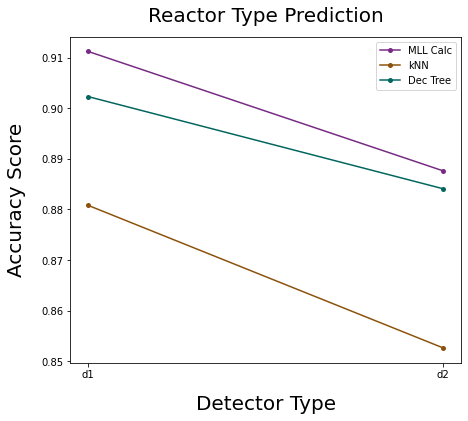

In [93]:
plot_curves('reactor', 'Reactor Type Prediction')

## Burnup

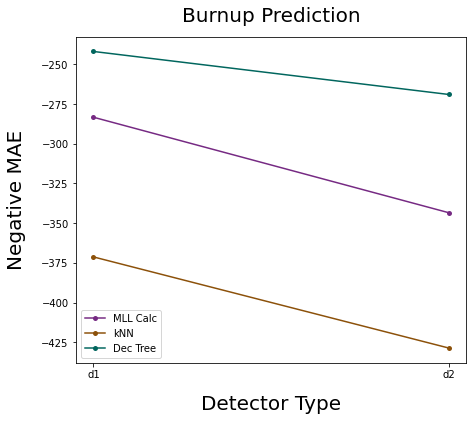

In [94]:
plot_curves('burnup', 'Burnup Prediction')

## Enrichment

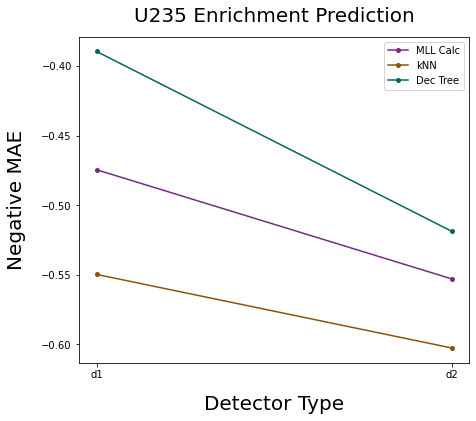

In [95]:
plot_curves('enrichment', 'U235 Enrichment Prediction')

## Time Since Irraditation

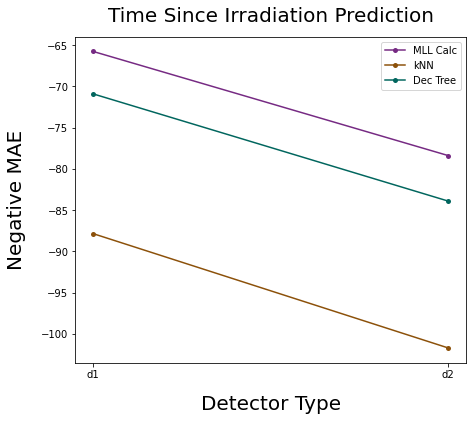

In [96]:
plot_curves('cooling', 'Time Since Irradiation Prediction')